# Herron Topic 4 - Practice - Sec 03

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import scipy.optimize as sco # new addition for portfolio optimization
import statsmodels.api as sm
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. Please complete TRACE! I use TRACE to improve my treaching and courses, and I value your feedback. More here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2753925>
2. Please plan for the in-class programming and MSFQ assessments on Tuesday, 4/15

## Five-Minute Recap

Please see the lecture notebook for an in-depth explanation of how we will use `sco.minimize()` for portfolio optimization.
Here are the key arguments to `sco.minimize()`:

1. `fun`: Name of function whose output we want to *minimize*
2. `x0`: First guess at inputs that *minimize* the output of the function in `fun`
3. `args`: A tuple of additional arguments to the function in `fun`
4. `bounds`: A list or tuple of tuples; For example, `((0, 1), (0, 1))` bounds inputs to fall between 0 and 1
5. `constraints`: A tuple of dictionaries with functions to constrain our inputs; For example, `{'type': 'eq', 'fun': lambda w: w.sum() - 1}` constraints te sum or our inputs to 1

##  Practice

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years

Note that `sco.minimize()` finds *minimums*, so you need to minimize the *negative* Sharpe Ratio.

In [3]:
mag7 = (
    yf.download(
        tickers='GOOGL AMZN AAPL META MSFT NVDA TSLA',
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1] # drop incomplete trading day
)

In [4]:
returns = mag7['Adj Close'].pct_change().iloc[-756:]

We need the risk-free rate of return to calculate Sharpe ratios.
French provides the risk-free rate of return as `RF` in most of his data sets.

In [5]:
ff3 = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
    .div(100)
)

C:\Users\richa\AppData\Local\Temp\ipykernel_912\582763811.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


The Sharpe ratio is the ratio of the mean portfolio *excess* return to the volatility of portfolio *excess* returns.
$$
S_p = \frac{\overline{r_p - r_f}}{\sigma(r_p - r_f)}
$$
We can simplify this calculation if we calculate a data frame of *excess* returns.
Then, we can use this data frame of excess returns to define the covariance matrix and mean returns.

In [6]:
returns_excess = returns.sub(ff3['RF'], axis=0)
Sigma_excess = returns_excess.cov()
mu_excess = returns_excess.mean()

The maximize the Sharpe ratio, we need to *minimize* the *negative* Sharpe ratio because there is no `maximize()` function.
To simplify our code, we can define `Sharpe_neg()` and `Sharpe()` functions.
We will use the former with `minimize()` and the latter everwhere else.
The `Sharpe()` function uses matrix math, where `@` is the Numpy and pandas symbol for matrix multiplication.

1. `w.T @ mu_excess` is code for $w' \mu_{\text{excess}}$
1. `w.T @ Sigma_excess @ w` is code for $w' \Sigma_{\text{excess}} \mu$

In [7]:
def Sharpe(w, Sigma_excess, mu_excess, ppy=252):
    return (ppy * w.T @ mu_excess) / np.sqrt(ppy * w.T @ Sigma_excess @ w)

In [8]:
def Sharpe_neg(w, Sigma_excess, mu_excess, ppy=252):
    return -1 * Sharpe(w=w, Sigma_excess=Sigma_excess, mu_excess=mu_excess, ppy=252)

In [9]:
def equal_weights(n):
    return np.ones(n) / n

In [10]:
equal_weights(Sigma_excess.shape[1])

array([0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429])

In [11]:
[(0, 1) for _ in range(Sigma_excess.shape[1])]

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

We can store our `minimize()` results in `res_X` and increment `X` for each of the following practices.

In [12]:
res_1 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[1]),
    args=(Sigma_excess, mu_excess),
    bounds=[(0, 1) for _ in range(7)],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)

We want to make sure that `minimize()` finds a solution (i.e., `res_1['success']` is `True`).
The *negative* Sharpe ratio is the value for the `fun` key, and the portfolio weights are the value for the `x` key.

In [13]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4135274558650675
       x: [ 0.000e+00  0.000e+00  0.000e+00  2.248e-01  1.195e-16
            7.752e-01  2.792e-17]
     nit: 6
     jac: [ 1.533e-01  3.427e-01  2.659e-01 -4.756e-05  2.516e-01
            1.378e-05  3.652e-01]
    nfev: 48
    njev: 6

We can save these results to a data frame for easy updating and plotting.

In [14]:
res_df = pd.DataFrame(
    data={'Max Sharpe, Long Only': res_1['x']},
    index=Sigma_excess.columns
)

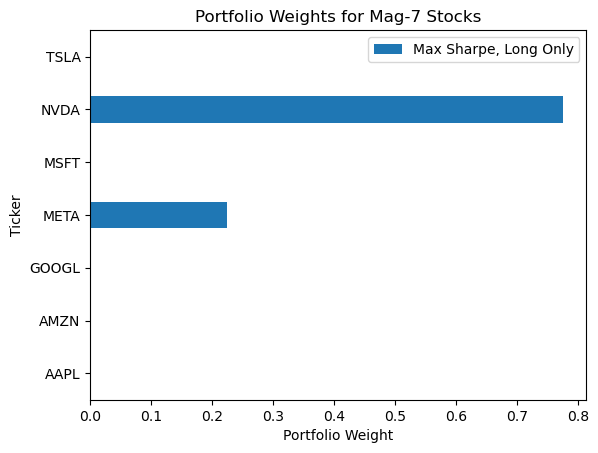

In [15]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

---

What if we want the actual, positive Sharpe ratio?
We can use the `Sharpe()` function.
If we want to update the results in `res_1`, we could write another helper function.
However, I generally give in and learn to live with the output of commonly used functions.

In [16]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.4135274558650675
       x: [ 0.000e+00  0.000e+00  0.000e+00  2.248e-01  1.195e-16
            7.752e-01  2.792e-17]
     nit: 6
     jac: [ 1.533e-01  3.427e-01  2.659e-01 -4.756e-05  2.516e-01
            1.378e-05  3.652e-01]
    nfev: 48
    njev: 6

In [17]:
Sharpe(w=res_1['x'], Sigma_excess=Sigma_excess, mu_excess=mu_excess)

1.4135

---

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but allow short weights up to 10% on each stock

We can short 6 of 7 stocks up to -0.1 for a total of -0.6.
Therefore, the maximum possible long weight is 1.6, and `bounds` becomes:
```python
    bounds=[(-0.1, 1.6) for _ in range(7)],
```

In [18]:
res_2 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[1]),
    args=(Sigma_excess, mu_excess),
    bounds=[(-0.1, 1.6) for _ in range(7)],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)

In [19]:
res_df['Max Sharpe, Short up to 10% Each'] = res_2['x']

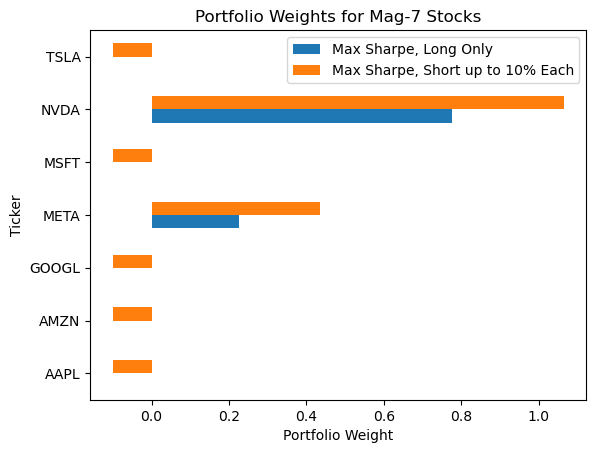

In [20]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but allow total short weights of up to 30%

We need to use an unequality constraints to make sure the *sum* of the negative portfolios weights is greater than -0.3.
We express inequality constraints with functions with non-negative outputs, so we use $\sum_i w_i[w_i < 0] + 0.3 \geq 0$.

We see that once we allow shorts greater than 30%, we spend almost all of this short budget on AMZN.

In [21]:
toy = np.arange(-2, 3)

In [22]:
toy[toy < 0].sum()

np.int64(-3)

In [23]:
res_3 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[1]),
    args=(Sigma_excess, mu_excess),
    bounds=[(-0.3, 1.3) for _ in range(7)],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1},
        {'type': 'ineq', 'fun': lambda x: x[x < 0].sum() + 0.3}
    )
)

In [24]:
res_df['Max Sharpe, Short up to 30% Total'] = res_3['x']

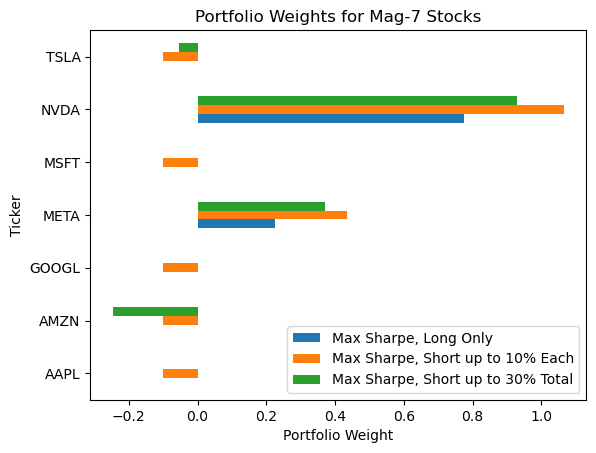

In [25]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the maximum Sharpe Ratio portfolio of Mag 7 stocks over the last three years, but do not allow any weight to exceed 30% in magnitude

We can bound all portfolios weights on $[0, 0.3]$ with:
```python
bounds=[(0, 0.3) for _ in range(7)]
```

In [26]:
res_4 = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess.shape[1]),
    args=(Sigma_excess, mu_excess),
    bounds=[(0, 0.3) for _ in range(7)],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)

In [27]:
res_df['Max Sharpe, Long Only up to 30% Each'] = res_4['x']

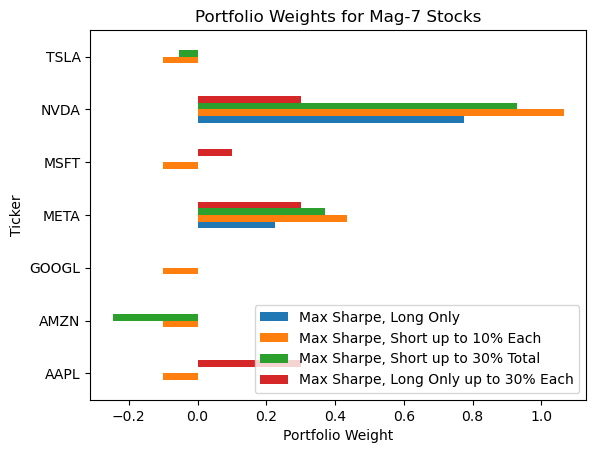

In [28]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the minimum 95% Value at Risk (Var) portfolio of Mag 7 stocks over the last three years

More on VaR [here](https://en.wikipedia.org/wiki/Value_at_risk).

In [29]:
def VaR(weights, returns, percent):
    return returns.dot(weights).quantile(1 - percent)

In [30]:
VaR(
    weights=equal_weights(returns.shape[1]),
    returns=returns,
    percent=0.95
)

-0.0338

In [31]:
def VaR_neg(weights, returns, percent):
    return -1 * VaR(weights=weights, returns=returns, percent=percent)

In [32]:
res_var = sco.minimize(
    fun=VaR_neg,
    x0=equal_weights(returns.shape[1]), # np.ones(7) / 7
    args=(returns, 0.95),
    bounds=[(0, 1) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)

In [33]:
res_df['Minimum 1-Day 95% VaR'] = res_var['x']

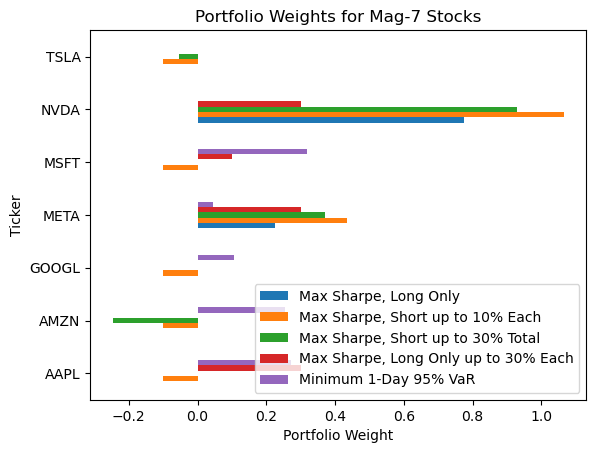

In [34]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the minimum draw down portfolio of Mag 7 stocks over the last three years

In [35]:
def Max_Drawdown(w, returns):
    price = returns.dot(w).add(1).cumprod()
    return (price / price.cummax() - 1).min()

In [36]:
Max_Drawdown(equal_weights(7), returns)

-0.3942

The maximum drawdown is a negative number, but we want the *smallest* negative number, so we minimize negative one times the maximum drawdown.

In [37]:
def Max_Drawdown_neg(w, returns):
    return -1 * Max_Drawdown(w=w, returns=returns)

In [38]:
res_mdd = sco.minimize(
    fun=Max_Drawdown_neg,
    x0=equal_weights(returns.shape[1]), # np.ones(7) / 7
    args=(returns,),
    bounds=[(0, 1) for _ in range(returns.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)

In [39]:
res_df['Min Max Drawdown'] = res_mdd['x']

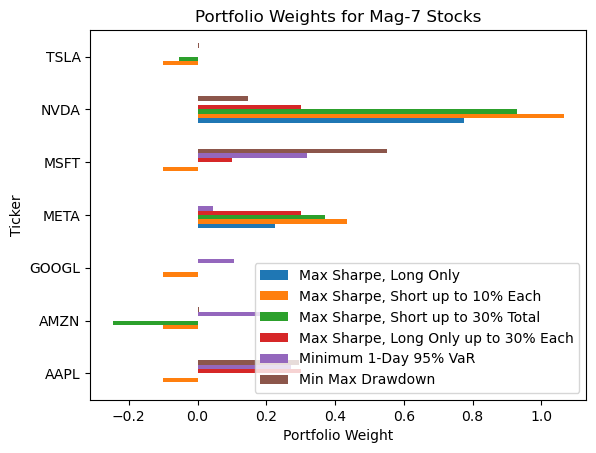

In [40]:
res_df.plot(kind='barh')
plt.title('Portfolio Weights for Mag-7 Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Find the minimum draw down portfolio for the sample with complete data for the current Dow-Jones Industrial Average (DJIA) stocks

You can find the [DJIA tickers on Wikipedia](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).

In [41]:
tickers = (
    pd.read_html(io='https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
    [2]
    ['Symbol']
    .to_list()
)

In [42]:
djia = (
    yf.download(
        tickers=tickers,
        auto_adjust=False,
        progress=False
    )
    .iloc[:-1]
    ['Adj Close']
    .pct_change()
    .dropna()
)

In [43]:
res_mdd = sco.minimize(
    fun=Max_Drawdown_neg,
    x0=equal_weights(djia.shape[1]),
    args=(djia,),
    bounds=[(0, 1) for _ in range(djia.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    )
)

In [44]:
res_djia = pd.DataFrame(
    data={'Min Max Drawdown': res_mdd['x']},
    index=djia.columns
)

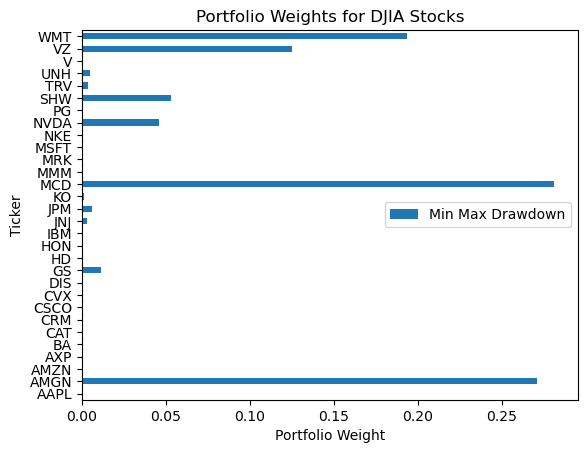

In [45]:
res_djia.plot(kind='barh')
plt.title('Portfolio Weights for DJIA Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

### Plot the minimum-variance frontier for the sample with complete data for the current the DJIA stocks

See the lecture notebook for a similar exercise with the Mag-7 stocks.

In [46]:
def calc_sigmap(w, Sigma, ppy=252):
    return np.sqrt(ppy * w.T @ Sigma @ w)

In [47]:
def calc_mup(w, mu, ppy=252):
    return ppy * w.T @ mu

In [48]:
Sigma = djia.cov()

In [49]:
mu = djia.mean()

In [50]:
djia_target = 252 * np.linspace(
    start=mu.min(),
    stop=mu.max(),
    num=50
)

In [51]:
res_ef = []

for r in djia_target:
    _ = sco.minimize(
        fun=calc_sigmap,
        x0=np.ones(Sigma.shape[1]) / Sigma.shape[1],
        args=(Sigma, 252),
        bounds=[(0, 1) for c in Sigma.index],
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            {'type': 'eq', 'fun': lambda x: calc_mup(w=x, mu=mu, ppy=252) - r}
        )
    )
    res_ef.append(_)

In [52]:
for r in res_ef:
    assert r['success'] 

In [53]:
mv_frontier = pd.DataFrame({
    'returns_target': djia_target,
    'volatility': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
})

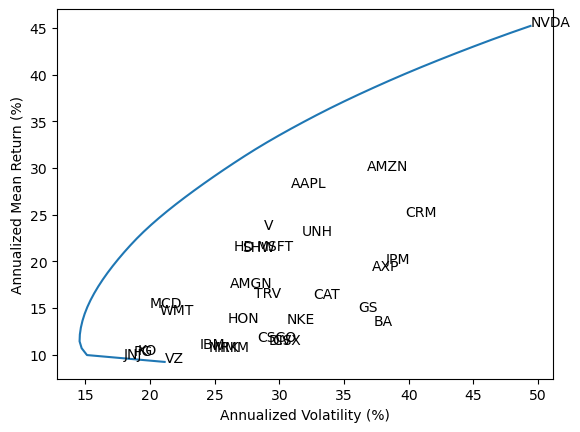

In [54]:
(
    mv_frontier
    .mul(100)
    .plot(x='volatility', y='returns_target', legend=False)
)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')

for t in Sigma.index:
    x = 100 * np.sqrt(252 * Sigma.loc[t, t])
    y = 100 * 252 * mu.loc[t]
    plt.annotate(text=t, xy=(x, y))
    
plt.show()

### Find the maximum Sharpe Ratio portfolio for the sample with complete data for the current the DJIA stocks excluding the last three years, so we can compare to the 1/n portfolio to the maximum Sharpe ratio portfolio

This exercise is less dramatic withe NVDA this year.
We will see three things:

1. The maximum Sharpe ratio portfolio has a high Sharpe ratio *in sample* (or what we called `_before` in class)
2. But this same portfolio has a much lower Sharpe ratio *out of sample* (or what we called `_after` in class)
3. The 1/N or equal-weighted portfolio has about the same Sharpe ratio as the maximum Sharpe ratio portfolio *out of sample*

In [55]:
djia_excess = djia.sub(ff3['RF'], axis=0)
Sigma_excess_before = djia_excess.iloc[:-756].cov()
mu_excess_before = djia_excess.iloc[:-756].mean()

In [56]:
Sigma_excess_after = djia_excess.iloc[-756:].cov()
mu_excess_after = djia_excess.iloc[-756:].mean()

In [57]:
res_before = sco.minimize(
    fun=Sharpe_neg,
    x0=equal_weights(Sigma_excess_before.shape[1]),
    args=(Sigma_excess_before, mu_excess_before),
    bounds=[(0, 1) for _ in range(Sigma_excess_before.shape[1])],
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1}
    )
)

The maximum Sharpe ratio portfolio has a high Sharpe ratio *in sample*!

In [58]:
Sharpe(
    w=res_before['x'],
    Sigma_excess=Sigma_excess_before,
    mu_excess=mu_excess_before,
    ppy=252
)

1.2129

In [59]:
res_djia['Max Sharpe Ratio 2008--2022'] = res_before['x']

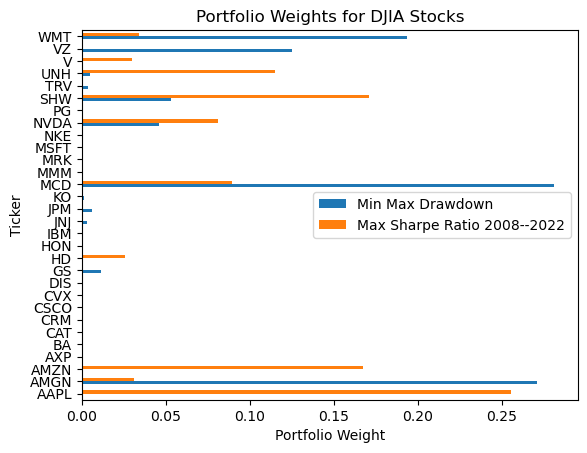

In [60]:
res_djia.plot(kind='barh')
plt.title('Portfolio Weights for DJIA Stocks')
plt.xlabel('Portfolio Weight')
plt.show()

The maximum Sharpe ratio portfolio has a much lower Sharpe ratio *out of sample*!

In [61]:
Sharpe(
    w=res_before['x'],
    Sigma_excess=Sigma_excess_after,
    mu_excess=mu_excess_after,
    ppy=252
)

0.7781

Furthermore, the 1/N or equal-weighted portfolio does about as well *out of sample*!

In [62]:
Sharpe(
    w=equal_weights(Sigma_excess_after.shape[1]),
    Sigma_excess=Sigma_excess_after,
    mu_excess=mu_excess_after,
    ppy=252
)

0.6697